In [4]:
import warnings
warnings.simplefilter(action='ignore')
import scanpy as sc
import anndata
import numpy as np
import gc
import pandas as pd 
import os
from datetime import date
from matplotlib.pyplot import rc_context
pd.set_option('display.max_columns', None)
import torch
import scarches as sca
import gdown
print(gc.isenabled())

 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0


True


In [2]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [5]:
path_project = '/nfs/research/irene/anaelle/CrossSpeciesIC'
print(path_project)
path_scripts = os.path.join(path_project, 'expiMap')
print(path_scripts)
path_data = os.path.join(path_project, 'data')
print(path_data)
path_data_res = os.path.join(path_scripts, 'expimap_results')
print(path_data_res)
path_models = os.path.join(path_scripts, 'expimap_models')
print(path_models)

/nfs/research/irene/anaelle/CrossSpeciesIC
/nfs/research/irene/anaelle/CrossSpeciesIC/expiMap
/nfs/research/irene/anaelle/CrossSpeciesIC/data
/nfs/research/irene/anaelle/CrossSpeciesIC/expiMap/expimap_results
/nfs/research/irene/anaelle/CrossSpeciesIC/expiMap/expimap_models


In [4]:
adata = sc.read_h5ad(os.path.join(path_data,'all_hhm_reduced.h5ad'))

In [5]:
GO = pd.read_csv(os.path.join(path_data,'GO_BP_human_gene_id_binary_matrix.csv'))

In [6]:
adata.layers["raw_counts"] = adata.X.copy()

In [7]:
mdata = adata[adata.obs.species == 'mouse']
mdata = mdata[mdata.obs.homolog_class_label == 'GABAergic']

In [8]:
GO = GO[GO.ensembl_gene_id.isin(mdata.var.index)]

In [9]:
mdata = mdata[:,mdata.var.human_ensembl_id.isin(GO.ensembl_gene_id)]

In [10]:
GO = GO.set_index('ensembl_gene_id')
GO['human_ensembl_id'] = GO.index

In [11]:
GOs = GO.reindex(mdata.var.index)
del GOs[GOs.columns[-1]]

In [12]:
GPs = GOs.to_numpy()

In [13]:
terms = GOs.columns.values

In [14]:
mdata.varm['I'] = GPs
mdata.uns['terms'] = terms

In [15]:
sc.pp.normalize_total(mdata)
sc.pp.log1p(mdata)
sc.pp.highly_variable_genes(mdata,
                            n_top_genes = 3000,
                            batch_key='species',
                            subset =True)

In [16]:
select_terms = mdata.varm['I'].sum(0)>8

In [17]:
mdata.uns['terms'] = np.array(mdata.uns['terms'])[select_terms].tolist()

In [18]:
mdata.varm['I'] = mdata.varm['I'][:,select_terms]

In [19]:
np.shape(mdata.varm['I'])

(3000, 470)

In [20]:
mdata._inplace_subset_var(mdata.varm['I'].sum(1)>0)
mdata.X = mdata.layers['raw_counts'].copy()

In [21]:
intr_cvae = sca.models.EXPIMAP(
    adata=mdata,
    condition_key='species',
    hidden_layer_sizes=[300, 300, 300],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2559 300 1
	Hidden Layer 1 in/out: 300 300
	Hidden Layer 2 in/out: 300 300
	Mean/Var Layer in/out: 300 470
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  470 0 0 1 2559
	with hard mask.
Last Decoder layer: softmax


In [22]:
ALPHA = 0.7

In [2]:
# These cells have been run in the expimap_adv_GABAergic_GO_reduced.py file

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.6,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

In [ ]:
MEAN = False

In [ ]:
mdata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [ ]:
sc.pp.neighbors(mdata, use_rep='X_cvae')
sc.tl.umap(mdata)

In [ ]:
sc.pl.umap(mdata, color=['species','homolog_subclass_label'], frameon=False, wspace=0.6)

In [ ]:
hdata = adata[adata.obs.species == 'human']
hdata = hdata[hdata.obs.homolog_class_label == 'GABAergic']
hdata = hdata[:,hdata.var.human_ensembl_id.isin(mdata.var_names)]
hdata.uns['terms'] = mdata.uns['terms']

In [ ]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(hdata, intr_cvae,
                                                 unfreeze_ext=True,
                                                 n_ext=100)

In [ ]:
q_intr_cvae.train(n_epochs=250,
                  alpha_epoch_anneal=120,
                  alpha_kl=0.1,
                  weight_decay=0.,
                  alpha_l1=0.96,
                  gamma_ext=0.7,
                  gamma_epoch_anneal=50,
                  beta=3.,
                  seed=2020,
                  use_early_stopping=False)

In [ ]:
q_intr_cvae.save(os.path.join(path_models,'hhm_reduced_GO_GABAergic_adv_'+str(date.today())))

In [ ]:
hmdata = sc.AnnData.concatenate(mdata, hdata, batch_key='batch_join', uns_merge='same')
hmdata.obsm['X_cvae'] = q_intr_cvae.get_latent(hmdata.X, hmdata.obs['species'], mean=MEAN, only_active=True)

In [ ]:
sc.pp.neighbors(hmdata, use_rep='X_cvae')
sc.tl.umap(hmdata)

# Results

## HVG = 3000, GP threshold = 8, first training = [300,300,300], ALPHA = 0.7, alpha_kl = 0.6 & 0.1, n_ext = 100

In [27]:
hmdata = sc.read_h5ad(os.path.join(path_data_res, 'hmdata_reduced_GABAergic_advanced_2023-07-18.h5ad'))

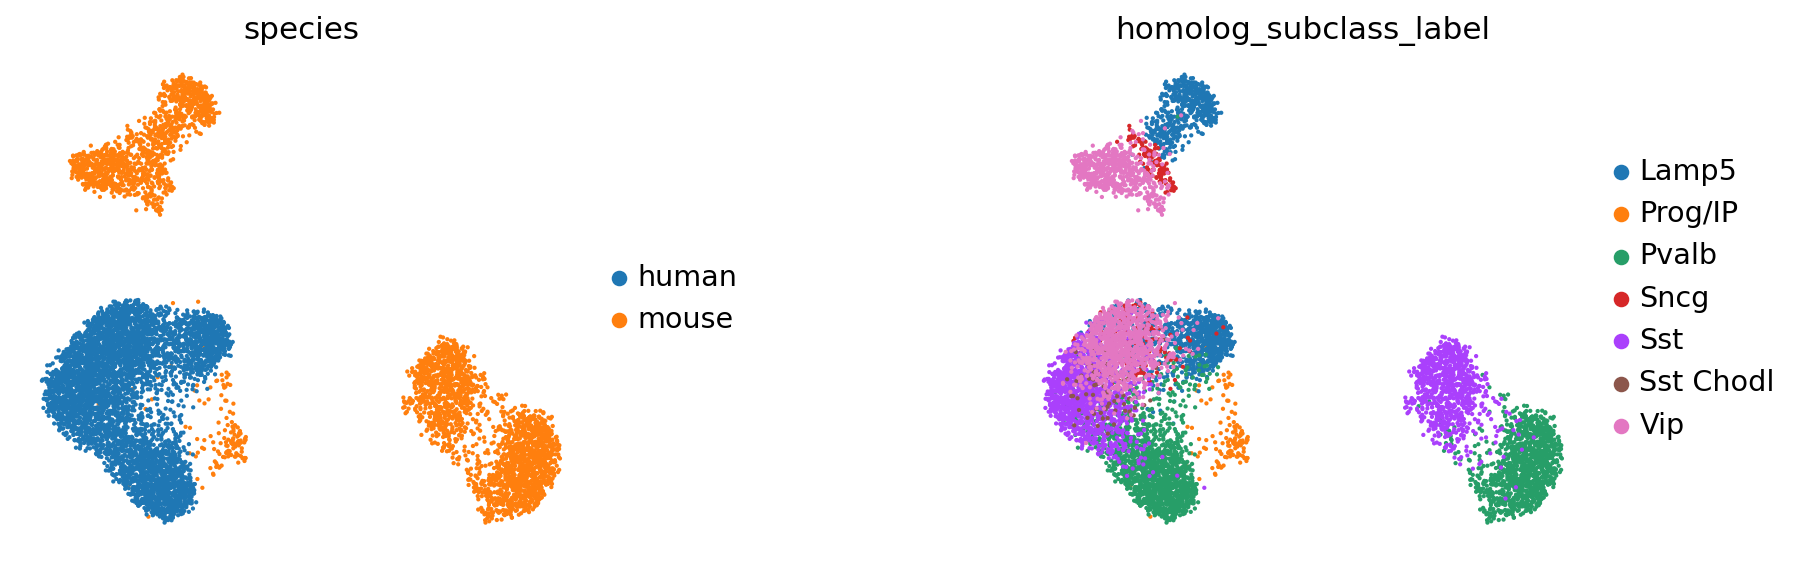

In [28]:
sc.pl.umap(hmdata, color=['species','homolog_subclass_label'], frameon=False, wspace=0.6)

## HVG = 3000, GP threshold = 8, first training = [300,300,300], ALPHA = 0.7, alpha_kl = 0.6 & 0.1, n_ext = 300

In [29]:
hmdata = sc.read_h5ad(os.path.join(path_data_res, 'hmdata_reduced_GABAergic_advanced_3k_2023-07-18.h5ad'))

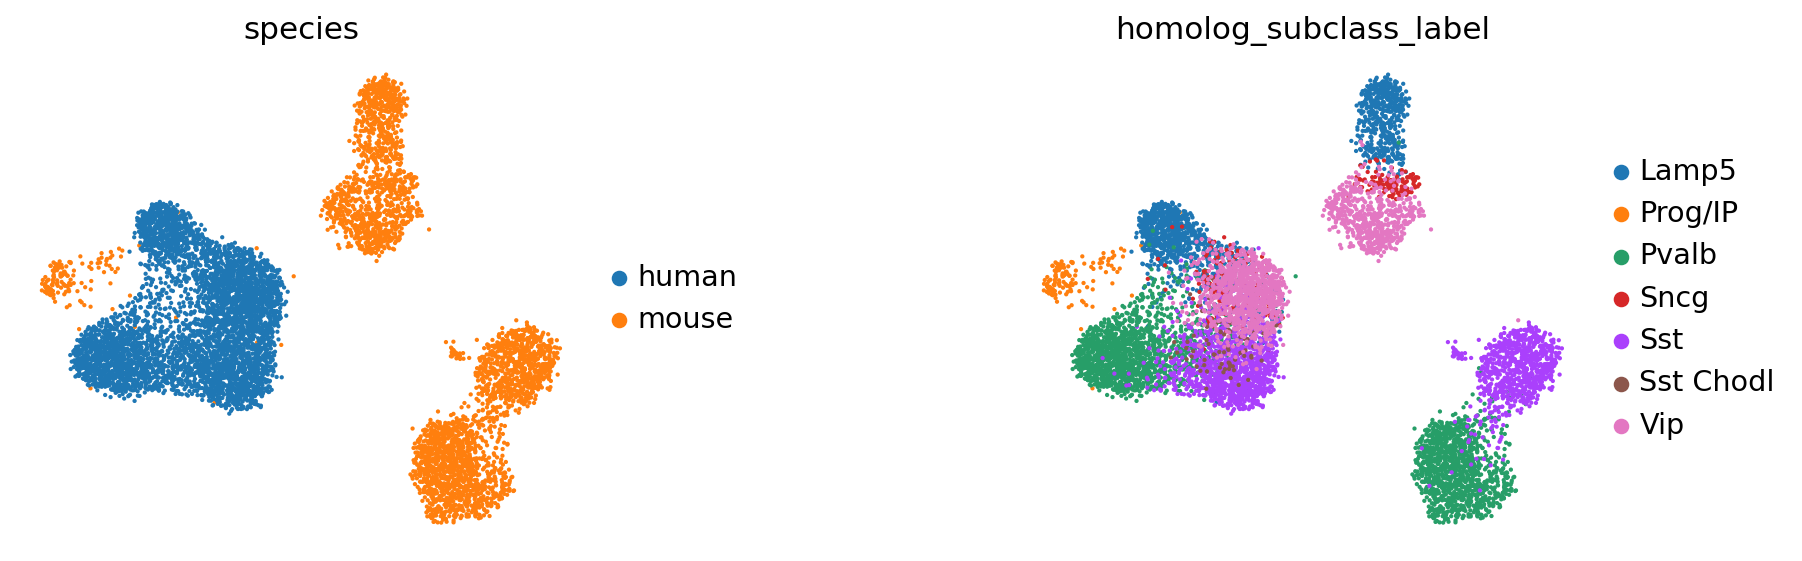

In [30]:
sc.pl.umap(hmdata, color=['species','homolog_subclass_label'], frameon=False, wspace=0.6)

## HVG = 3000, GP threshold = 8, first training = [300,300,300], ALPHA = 0.7, alpha_kl = 0.6 & 0.1, n_ext = 450

In [31]:
hmdata = sc.read_h5ad(os.path.join(path_data_res, 'hmdata_reduced_GABAergic_advanced_450_2023-07-18.h5ad'))

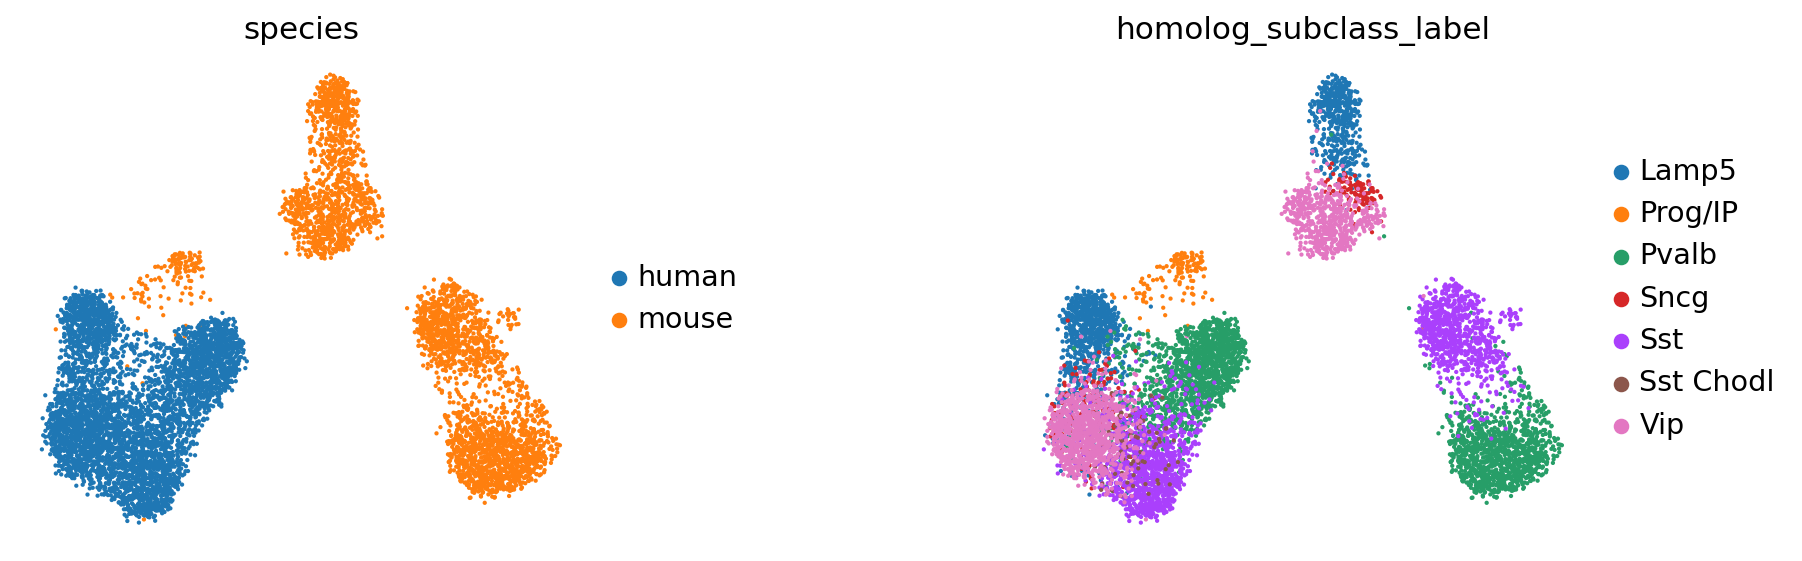

In [32]:
sc.pl.umap(hmdata, color=['species','homolog_subclass_label'], frameon=False, wspace=0.6)